In [0]:
import numpy as np
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense,AveragePooling2D
import keras
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
#Data preparation - Splitting set

batch_size=64

# Load train- and test-data from CIFAR-100-dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

# Get indices where class-label is 6(household furniture) and 7(insects) 
indices_train = np.where( (y_train == 6) | (y_train == 7))[0]
indices_test = np.where((y_test == 6) | (y_test == 7))[0]

# Reduce class labels
y_train = np.array(y_train[indices_train])
y_test = np.array(y_test[indices_test])
# Reduce train- and test-data
x_train = x_train[indices_train]
x_test = x_test[indices_test]

# Replace current class labels (6,7) to (0, 1); Needed for one-hot encoding
y_train[np.array(y_train==6)]=0
y_train[np.array(y_train==7)]=1                        
y_test[np.array(y_test==6)]=0
y_test[np.array(y_test==7)]=1  


# Convert class labels to one-hot labels
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

# Cast train- and test-data to float values
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize data from [0;255] to [0;1]
x_train /= 255
x_test /= 255

# Split train-data for validation (size of validation-data equals size of test-data)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20,stratify=y_train)



In [0]:
#Data augmentation
datagen = ImageDataGenerator(
    #rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)


In [0]:
# CNN MODEL STRUCTURE FOR COARSE CLASSES
# Create linear stack of layers
model = Sequential()

# Add first convolution
model.add(Conv2D(filters=32,kernel_size=3,activation='elu',data_format="channels_last",input_shape=(32, 32, 3),strides=1,padding="valid",kernel_initializer="lecun_uniform",name="h1_conv"))

# Add first max-pooling
model.add(MaxPooling2D(pool_size=2,name="h1_pool"))

# Add first dropout
model.add(Dropout(rate=0.2,name="h1_drop"))

# Add second convolution
model.add(Conv2D(filters=32,kernel_size=3,activation='elu',strides=1,padding="valid",kernel_initializer="lecun_uniform",name="h2_conv"))

# Add second max-pooling
model.add(MaxPooling2D(pool_size=2,name="h2_pool"))

# Add second dropout
model.add(Dropout(rate=0.2,name="h2_drop"))

# Add third convolution
model.add(Conv2D(filters=32,kernel_size=3,activation='elu',strides=1,padding="valid",kernel_initializer="lecun_uniform",name="h3_conv"))

# Add third max-pooling   -may need AveragePooling2D
model.add(AveragePooling2D(pool_size=2,name="h3_pool"))

# Add third dropout
model.add(Dropout(rate=0.2,name="h3_drop"))

# Reduce dimensionality
model.add(Flatten())

# Add fully-connected layer
model.add(Dense(units=128,activation='elu',name="h4_dense"))

# Add fully-connected output layer
model.add(Dense(units=2,activation='softmax',name="out"))

# Save model to file
#model.save("model.h5")
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1_conv (Conv2D)             (None, 30, 30, 32)        896       
_________________________________________________________________
h1_pool (MaxPooling2D)       (None, 15, 15, 32)        0         
_________________________________________________________________
h1_drop (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
h2_conv (Conv2D)             (None, 13, 13, 32)        9248      
_________________________________________________________________
h2_pool (MaxPooling2D)       (None, 6, 6, 32)          0         
_________________________________________________________________
h2_drop (Dropout)            (None, 6, 6, 32)          0         
_________________________________________________________________
h3_conv (Conv2D)             (None, 4, 4, 32)          9248      
__________

Epoch 1/10
2000/2000 [==============================] - 25s 12ms/step - loss: 0.0853 - acc: 0.8833 - val_loss: 0.0619 - val_acc: 0.9180

Epoch 00001: val_loss improved from inf to 0.06192, saving model to model23.h5
Epoch 2/10
2000/2000 [==============================] - 23s 12ms/step - loss: 0.0466 - acc: 0.9389 - val_loss: 0.0486 - val_acc: 0.9370

Epoch 00002: val_loss improved from 0.06192 to 0.04864, saving model to model23.h5
Epoch 3/10
2000/2000 [==============================] - 23s 12ms/step - loss: 0.0333 - acc: 0.9566 - val_loss: 0.0559 - val_acc: 0.9280

Epoch 00003: val_loss did not improve from 0.04864
Epoch 4/10
2000/2000 [==============================] - 23s 12ms/step - loss: 0.0259 - acc: 0.9672 - val_loss: 0.0478 - val_acc: 0.9440

Epoch 00004: val_loss improved from 0.04864 to 0.04778, saving model to model23.h5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
2000/2000 [==============================] - 23s 12ms/step - los

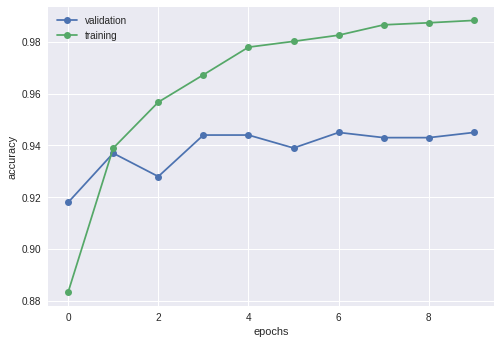

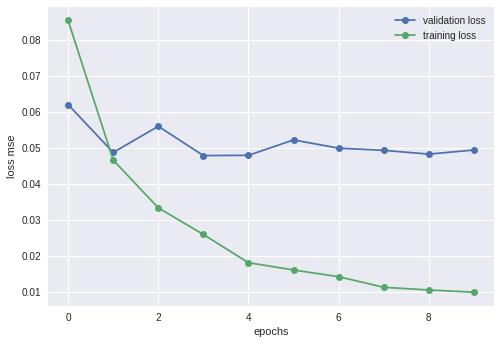

In [0]:
# COMPILE MODEL AND GET RESULTS
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,CSVLogger,LearningRateScheduler
import keras.backend as K

import time

class TimeHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.start_time = time.time()
  def on_train_end(self, logs={}):
    self.result=(time.time()-self.start_time)
    print("Training time= ",self.result)
     
time_history  = TimeHistory()

# Define custom callback
class lr_history(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.lr = []
    def on_epoch_begin(self, batch, logs={}):
      self.lr.append(K.eval(self.model.optimizer.lr))
      #print(K.eval(self.model.optimizer.lr))

#lr = LearningRateScheduler(step_decay)
learn_history =lr_history()
checkpoint_callback = ModelCheckpoint('model23.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping_callback = EarlyStopping(monitor='loss', min_delta=0.01, patience=5, verbose=1, mode='auto')
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.05, cooldown=0, min_lr=1e-10)
csv_logger = CSVLogger('training.log')

cb =[early_stopping_callback,checkpoint_callback,reduce_plateau,csv_logger,learn_history,time_history]
#opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
optim = keras.optimizers.Adam(lr=0.001,decay=1e-6)
#optim = keras.optimizers.SGD (lr=0.001,decay=1e-6,momentum=0.2)
model.compile(loss='mean_squared_error', optimizer=optim , metrics=['accuracy'])
results = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),\
                    steps_per_epoch=2000,epochs=10,\
                    verbose=1,validation_data=(x_valid,y_valid),callbacks = cb,shuffle=True)
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model2.h5') 
 
#testing
scores = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))



plt.plot(results.epoch,results.history['val_acc'],'-o',label='validation')
plt.plot(results.epoch,results.history['acc'],'-o',label='training')

plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.show()

# Plot training loss and validation loss per epoch
plt.plot(results.epoch,results.history['val_loss'],'-o',label='validation loss')
plt.plot(results.epoch,results.history['loss'],'-o',label='training loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss mse')
plt.grid(True)
plt.show()

In [0]:
print((time_history.result))

0.943


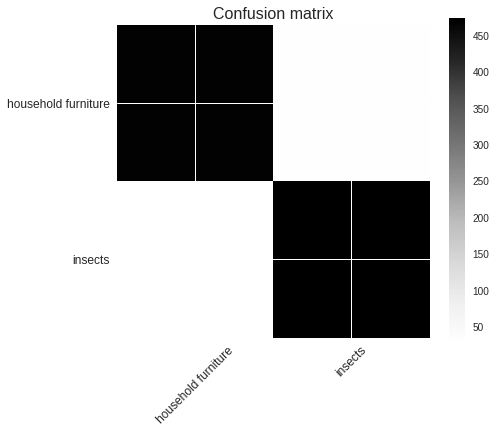

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score

cifar_classes = ["household furniture", "insects"]

y_pred = model.predict(x_test, batch_size=batch_size)

#print(y_test.shape)
y_pred2 = np.argmax(y_pred,axis=1)
#print(y_pred.shape)
#y_test2=y_test
y_test2 = np.argmax(y_test,axis=1)
accuracy = (len(y_test2) - np.count_nonzero(y_pred2 - y_test2))/len(y_test2)
print(accuracy)

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test2,y_pred2))
plt.xticks(np.arange(2), cifar_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(2), cifar_classes, fontsize=12)
plt.colorbar()
plt.show()
#print("Test accuracy:", accuracy_score(y_test, y_pred))

In [0]:
cm =confusion_matrix(y_test2,y_pred2)
print(cm)
acc_per_label = cm.diagonal()/cm.sum(axis=1)
acc_per_label_final = [cifar_classes[i]+ " = "+str(acc_per_label[i]) for i in range(0,2)]
print(acc_per_label_final)

[[469  31]
 [ 26 474]]
['household furniture = 0.938', 'insects = 0.948']
